In [255]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import optuna

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from scipy.stats import yeojohnson, boxcox
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_curve

warnings.filterwarnings("ignore")

%matplotlib inline

# Load Dataset

In [2]:
train_data = pd.read_csv('Data/loan_data_2007_2014.csv')
train_data.head()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
train_data.describe()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
count,466285.000000,4.662850e+05,4.662850e+05,466285.000000,466285.000000,466285.000000,466285.000000,466285.000000,4.662810e+05,466285.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,3.960090e+05,0.0,0.0,0.0
mean,233142.000000,1.307973e+07,1.459766e+07,14317.277577,14291.801044,14222.329888,13.829236,432.061201,7.327738e+04,17.218758,...,NaN,NaN,NaN,NaN,NaN,NaN,3.037909e+04,NaN,NaN,NaN
std,134605.029472,1.089371e+07,1.168237e+07,8286.509164,8274.371300,8297.637788,4.357587,243.485550,5.496357e+04,7.851121,...,NaN,NaN,NaN,NaN,NaN,NaN,3.724713e+04,NaN,NaN,NaN
min,0.000000,5.473400e+04,7.047300e+04,500.000000,500.000000,0.000000,5.420000,15.670000,1.896000e+03,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN
25%,116571.000000,3.639987e+06,4.379705e+06,8000.000000,8000.000000,8000.000000,10.990000,256.690000,4.500000e+04,11.360000,...,NaN,NaN,NaN,NaN,NaN,NaN,1.350000e+04,NaN,NaN,NaN
50%,233142.000000,1.010790e+07,1.194108e+07,12000.000000,12000.000000,12000.000000,13.660000,379.890000,6.300000e+04,16.870000,...,NaN,NaN,NaN,NaN,NaN,NaN,2.280000e+04,NaN,NaN,NaN
75%,349713.000000,2.073121e+07,2.300154e+07,20000.000000,20000.000000,19950.000000,16.490000,566.580000,8.896000e+04,22.780000,...,NaN,NaN,NaN,NaN,NaN,NaN,3.790000e+04,NaN,NaN,NaN
max,466284.000000,3.809811e+07,4.086083e+07,35000.000000,35000.000000,35000.000000,26.060000,1409.990000,7.500000e+06,39.990000,...,NaN,NaN,NaN,NaN,NaN,NaN,9.999999e+06,NaN,NaN,NaN


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   466285 non-null  int64  
 1   id                           466285 non-null  int64  
 2   member_id                    466285 non-null  int64  
 3   loan_amnt                    466285 non-null  int64  
 4   funded_amnt                  466285 non-null  int64  
 5   funded_amnt_inv              466285 non-null  float64
 6   term                         466285 non-null  object 
 7   int_rate                     466285 non-null  float64
 8   installment                  466285 non-null  float64
 9   grade                        466285 non-null  object 
 10  sub_grade                    466285 non-null  object 
 11  emp_title                    438697 non-null  object 
 12  emp_length                   445277 non-null  object 
 13 

# Drop Missing Value

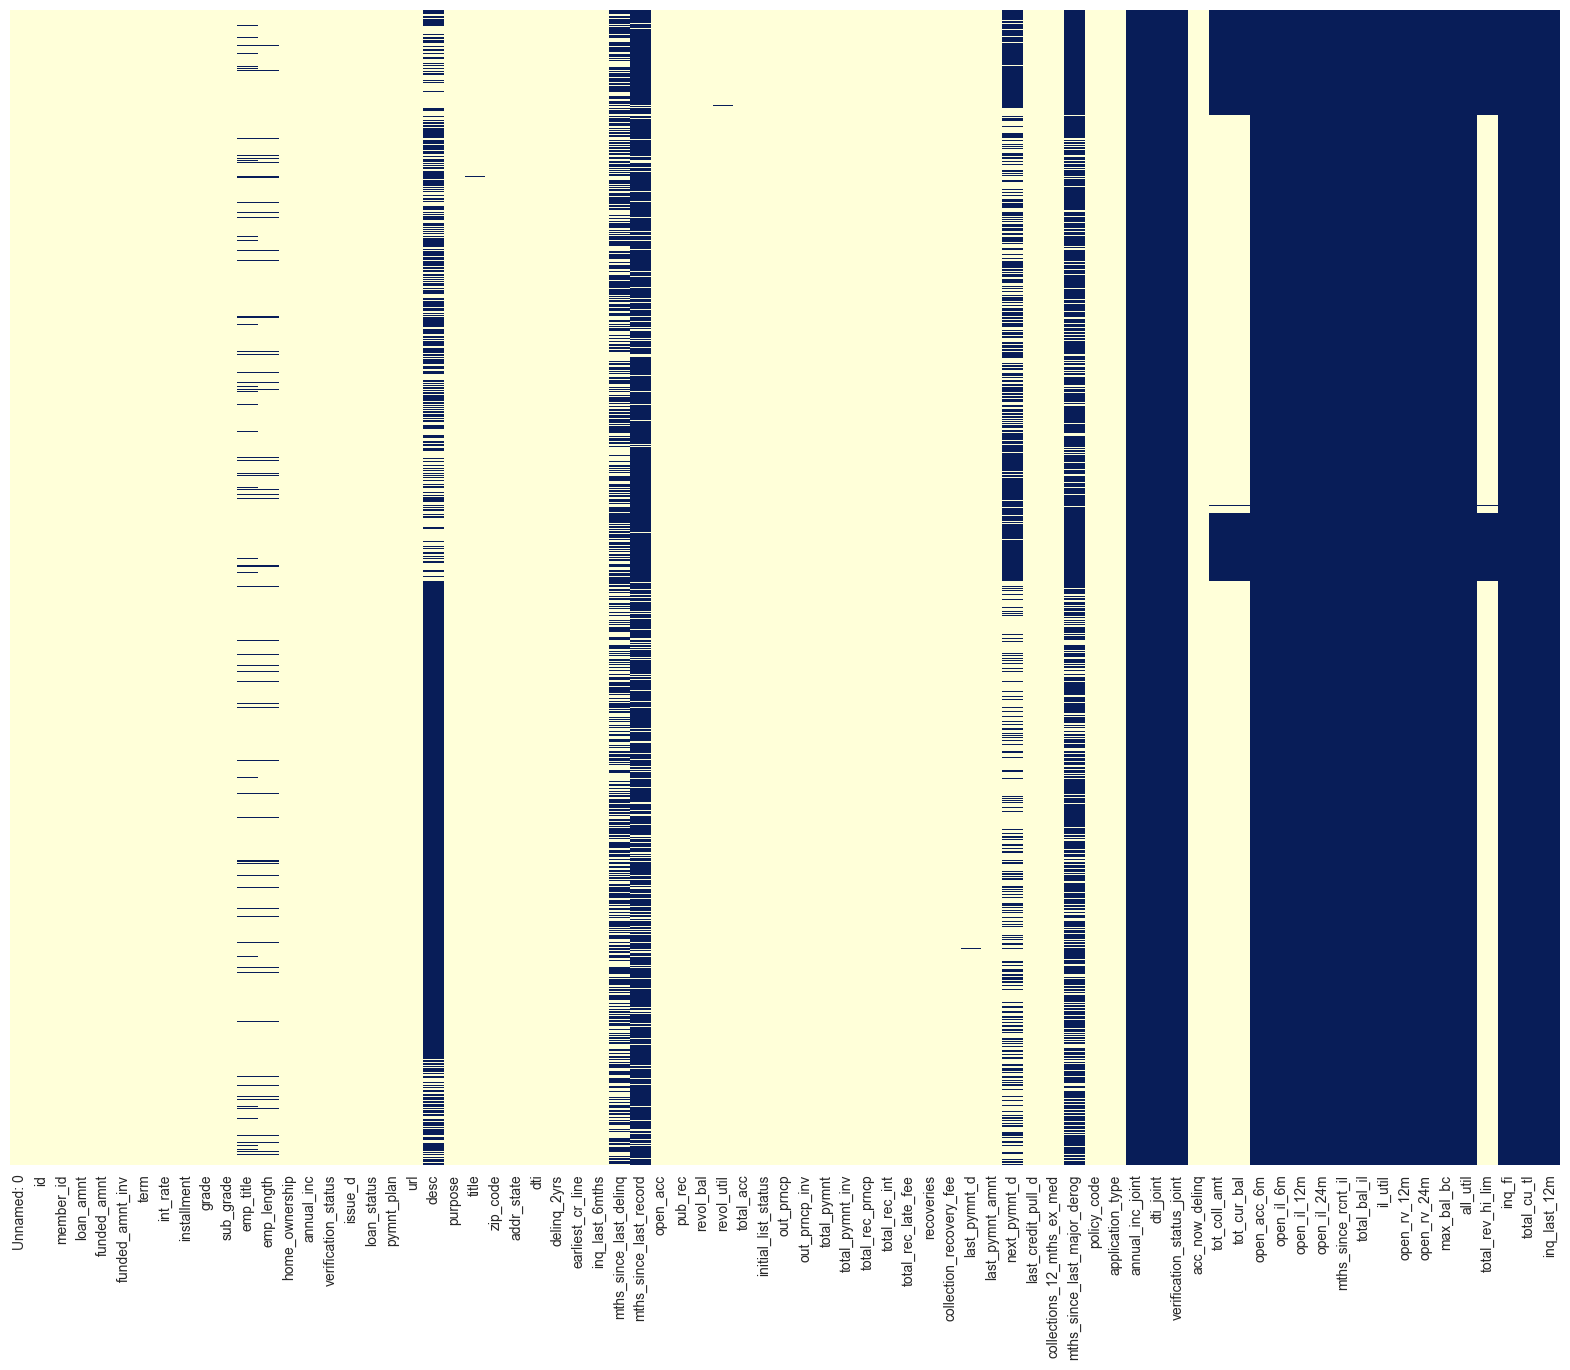

In [5]:
plt.figure(figsize=(20,15))
sns.heatmap(train_data.isnull(),yticklabels=False,cbar=False,cmap='YlGnBu')
plt.show()

In [6]:
train_data.drop(columns=['inq_fi', 'total_cu_tl', 'inq_last_12m', 'open_acc_6m', 'open_il_6m', 'open_il_12m',
                         'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util',
                         'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util',  'annual_inc_joint', 'dti_joint',
                         'verification_status_joint', 'mths_since_last_major_derog', 'next_pymnt_d',
                         'mths_since_last_delinq', 'mths_since_last_record', 'desc'], inplace=True)

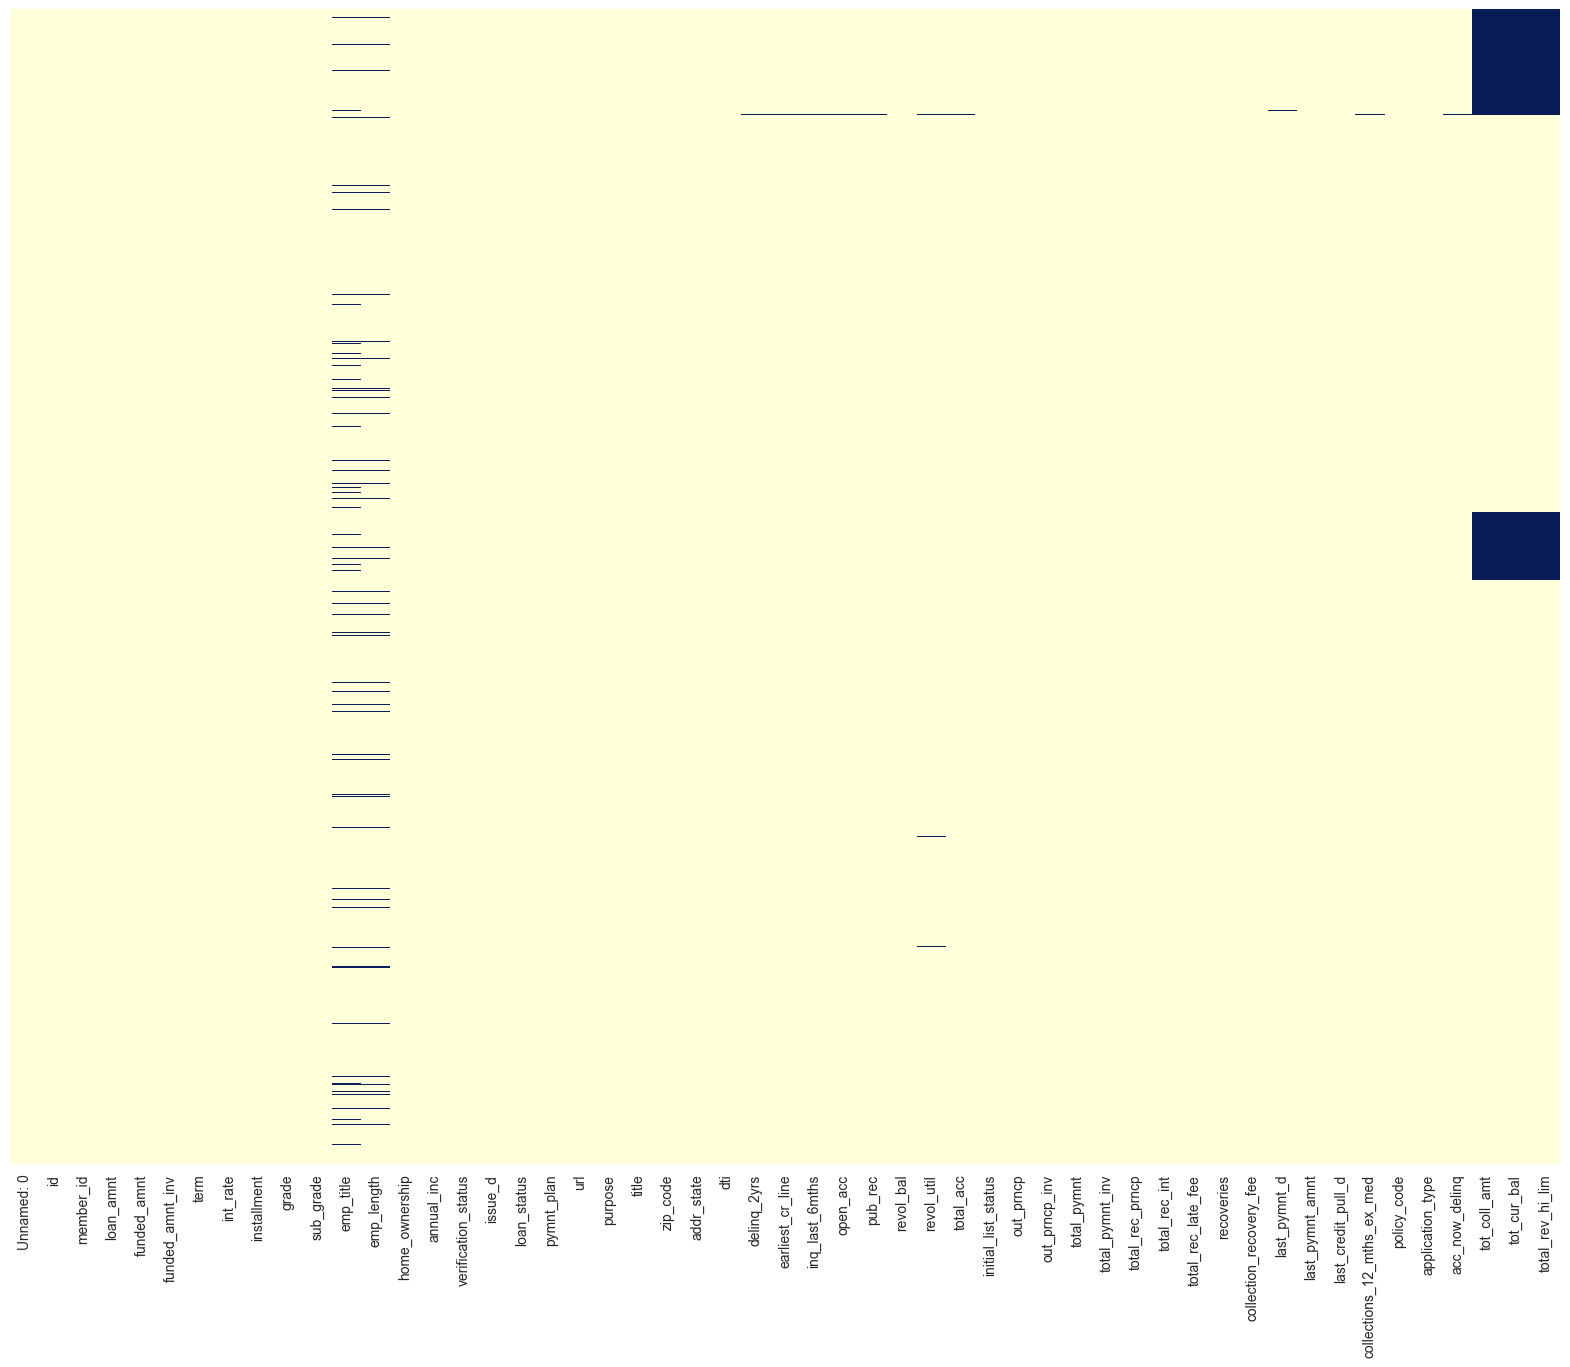

In [7]:
plt.figure(figsize=(20,15))
sns.heatmap(train_data.isnull(),yticklabels=False,cbar=False,cmap='YlGnBu')
plt.show()

# Penentuan Target
### Penentuan target didasarkan pada fitur loan status 

In [8]:
nan_kolom = ['emp_title', 'emp_length', 'revol_util', 'tot_']

loan_status_map = {
    'Charged Off': 'Bad',
    'Late (31-120 days)': 'Bad',
    'Default': 'Bad',
    'Does not meet the credit policy. Status:Charged Off': 'Bad',
    'Current': 'Good',
    'Fully Paid': 'Good',
    'In Grace Period': 'Good',
    'Does not meet the credit policy. Status:Fully Paid': 'Good',
    'Late (16-30 days)': 'Bad'
}

train_data['loan_category'] = train_data['loan_status'].map(loan_status_map)

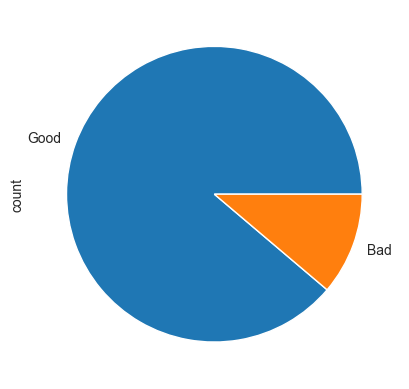

In [9]:
train_data['loan_category'].value_counts().plot(kind='pie')
plt.show()

# Exploratory Data Analysis

In [10]:
bad_data = train_data[train_data['loan_category'] == 'Bad']
good_data = train_data[train_data['loan_category'] == 'Good']

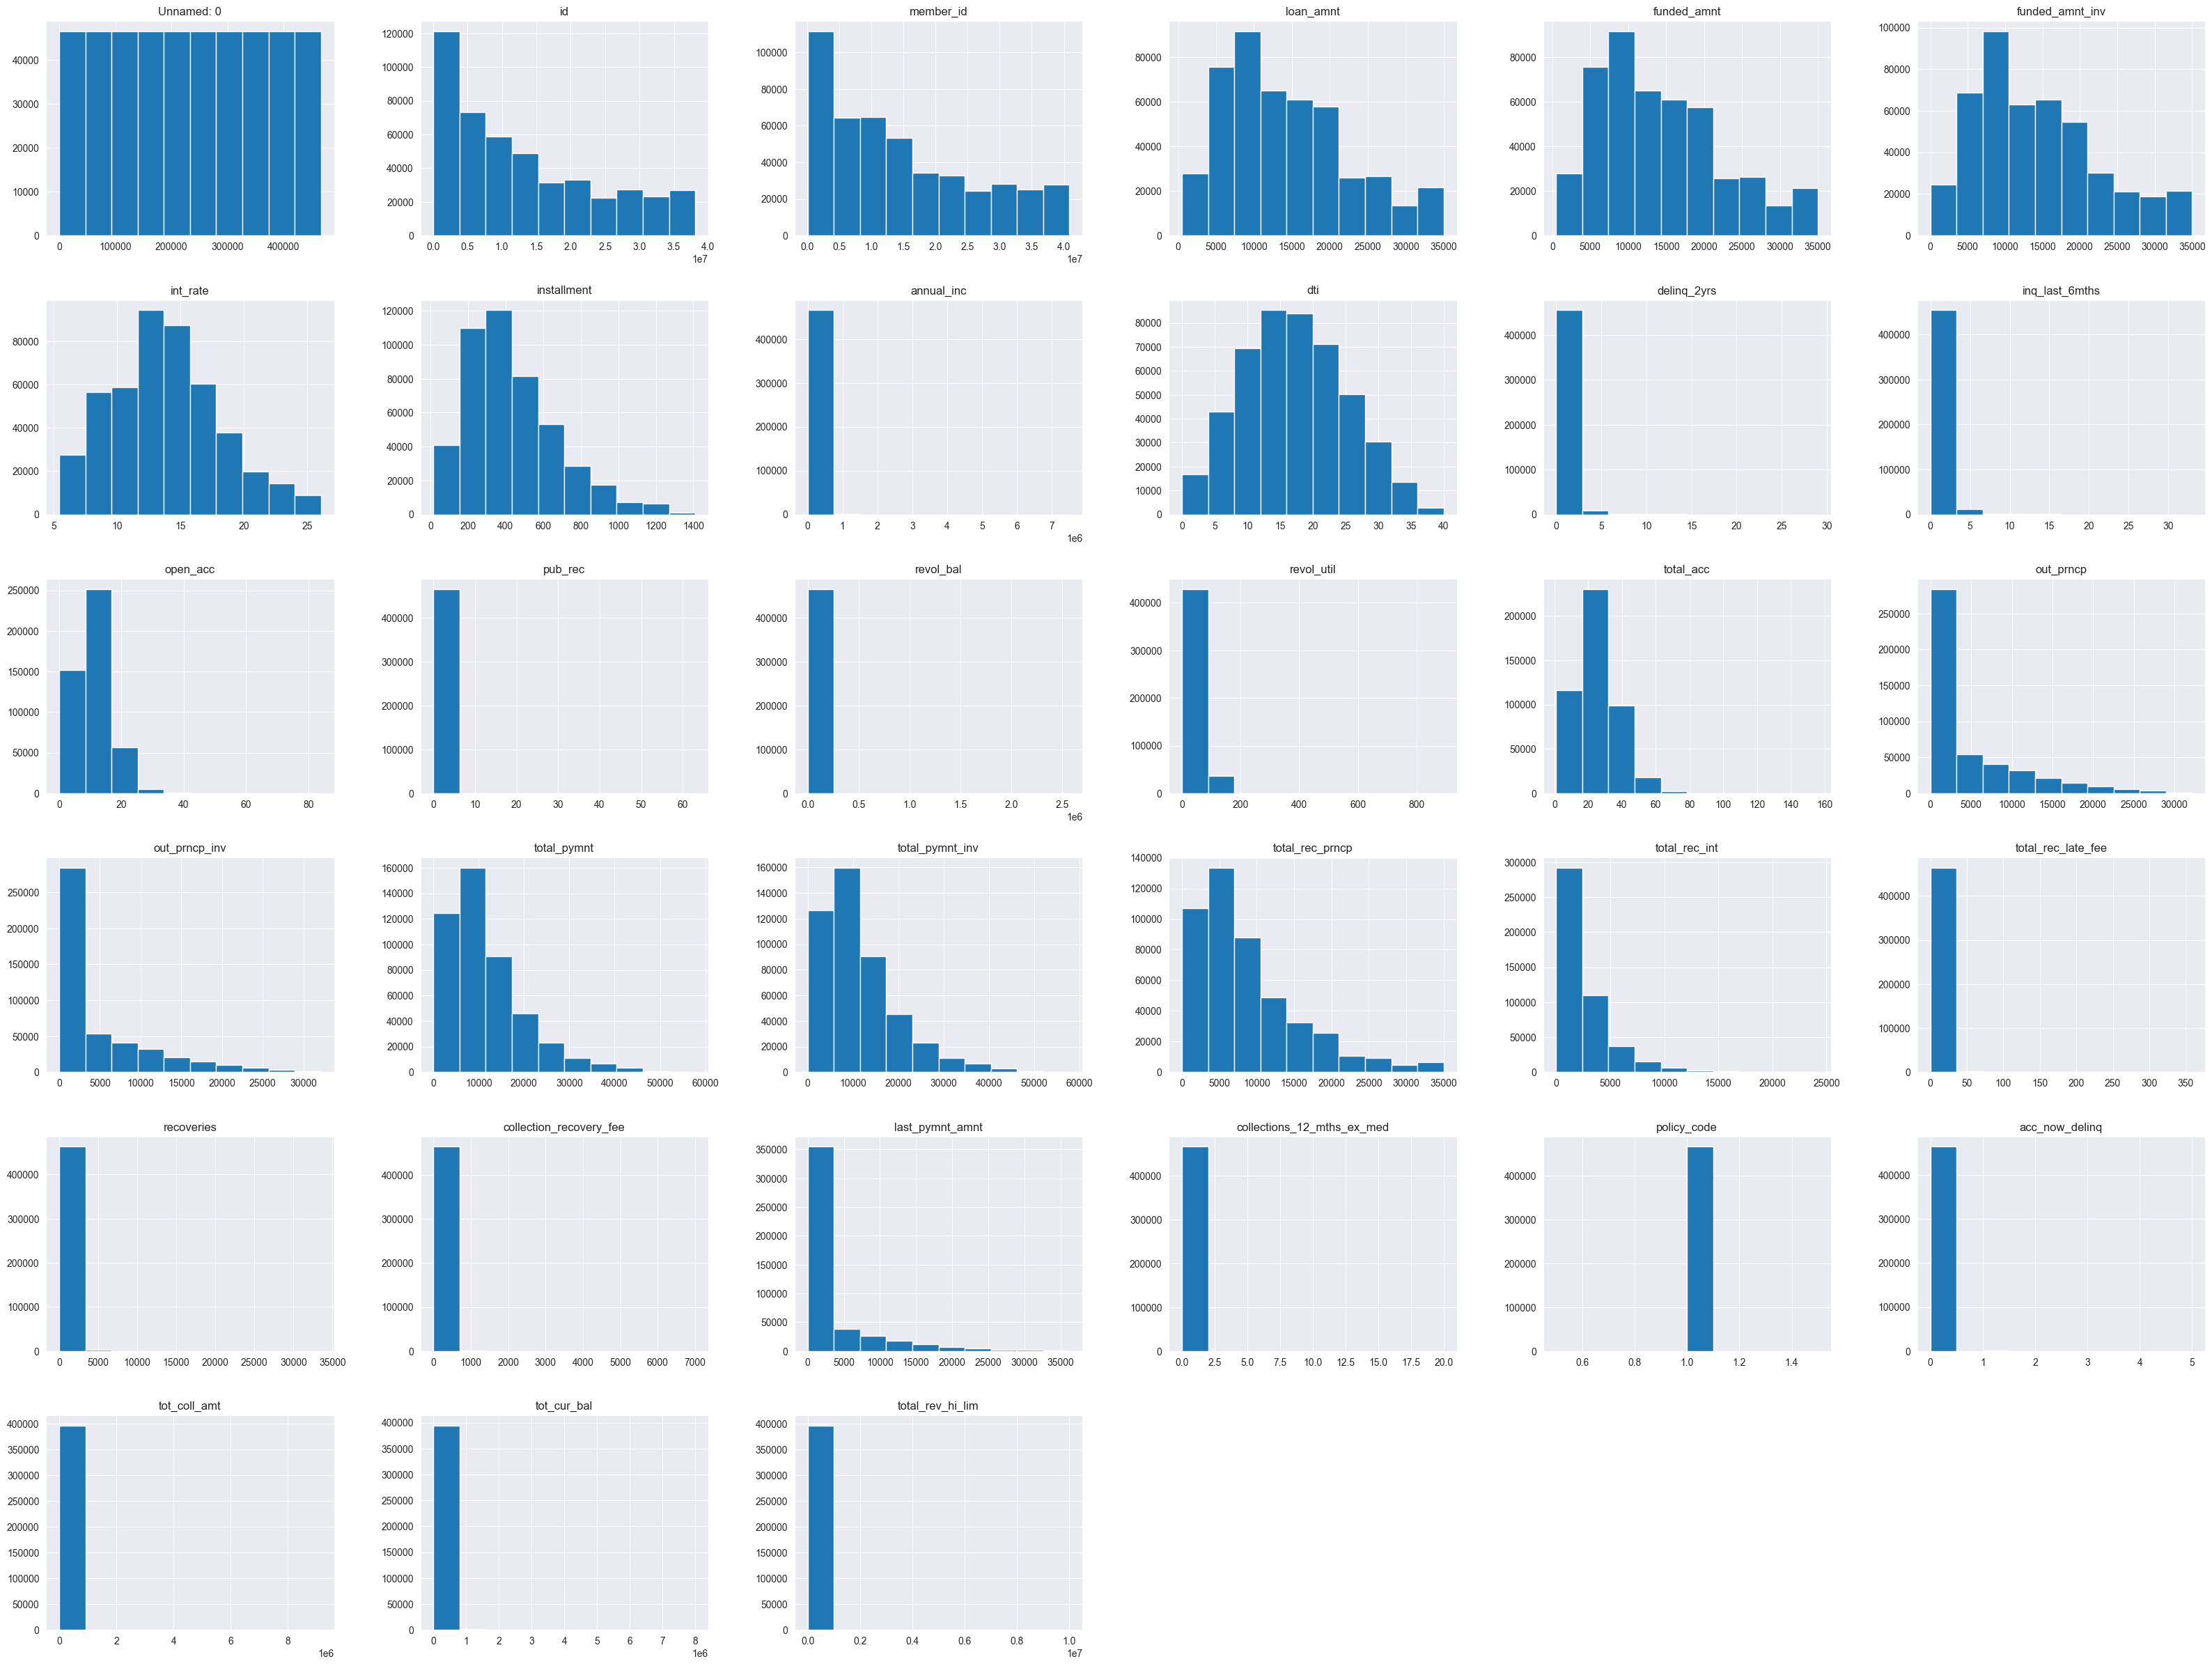

In [11]:
train_data.hist(figsize=(40,30), bins=10)
plt.show()

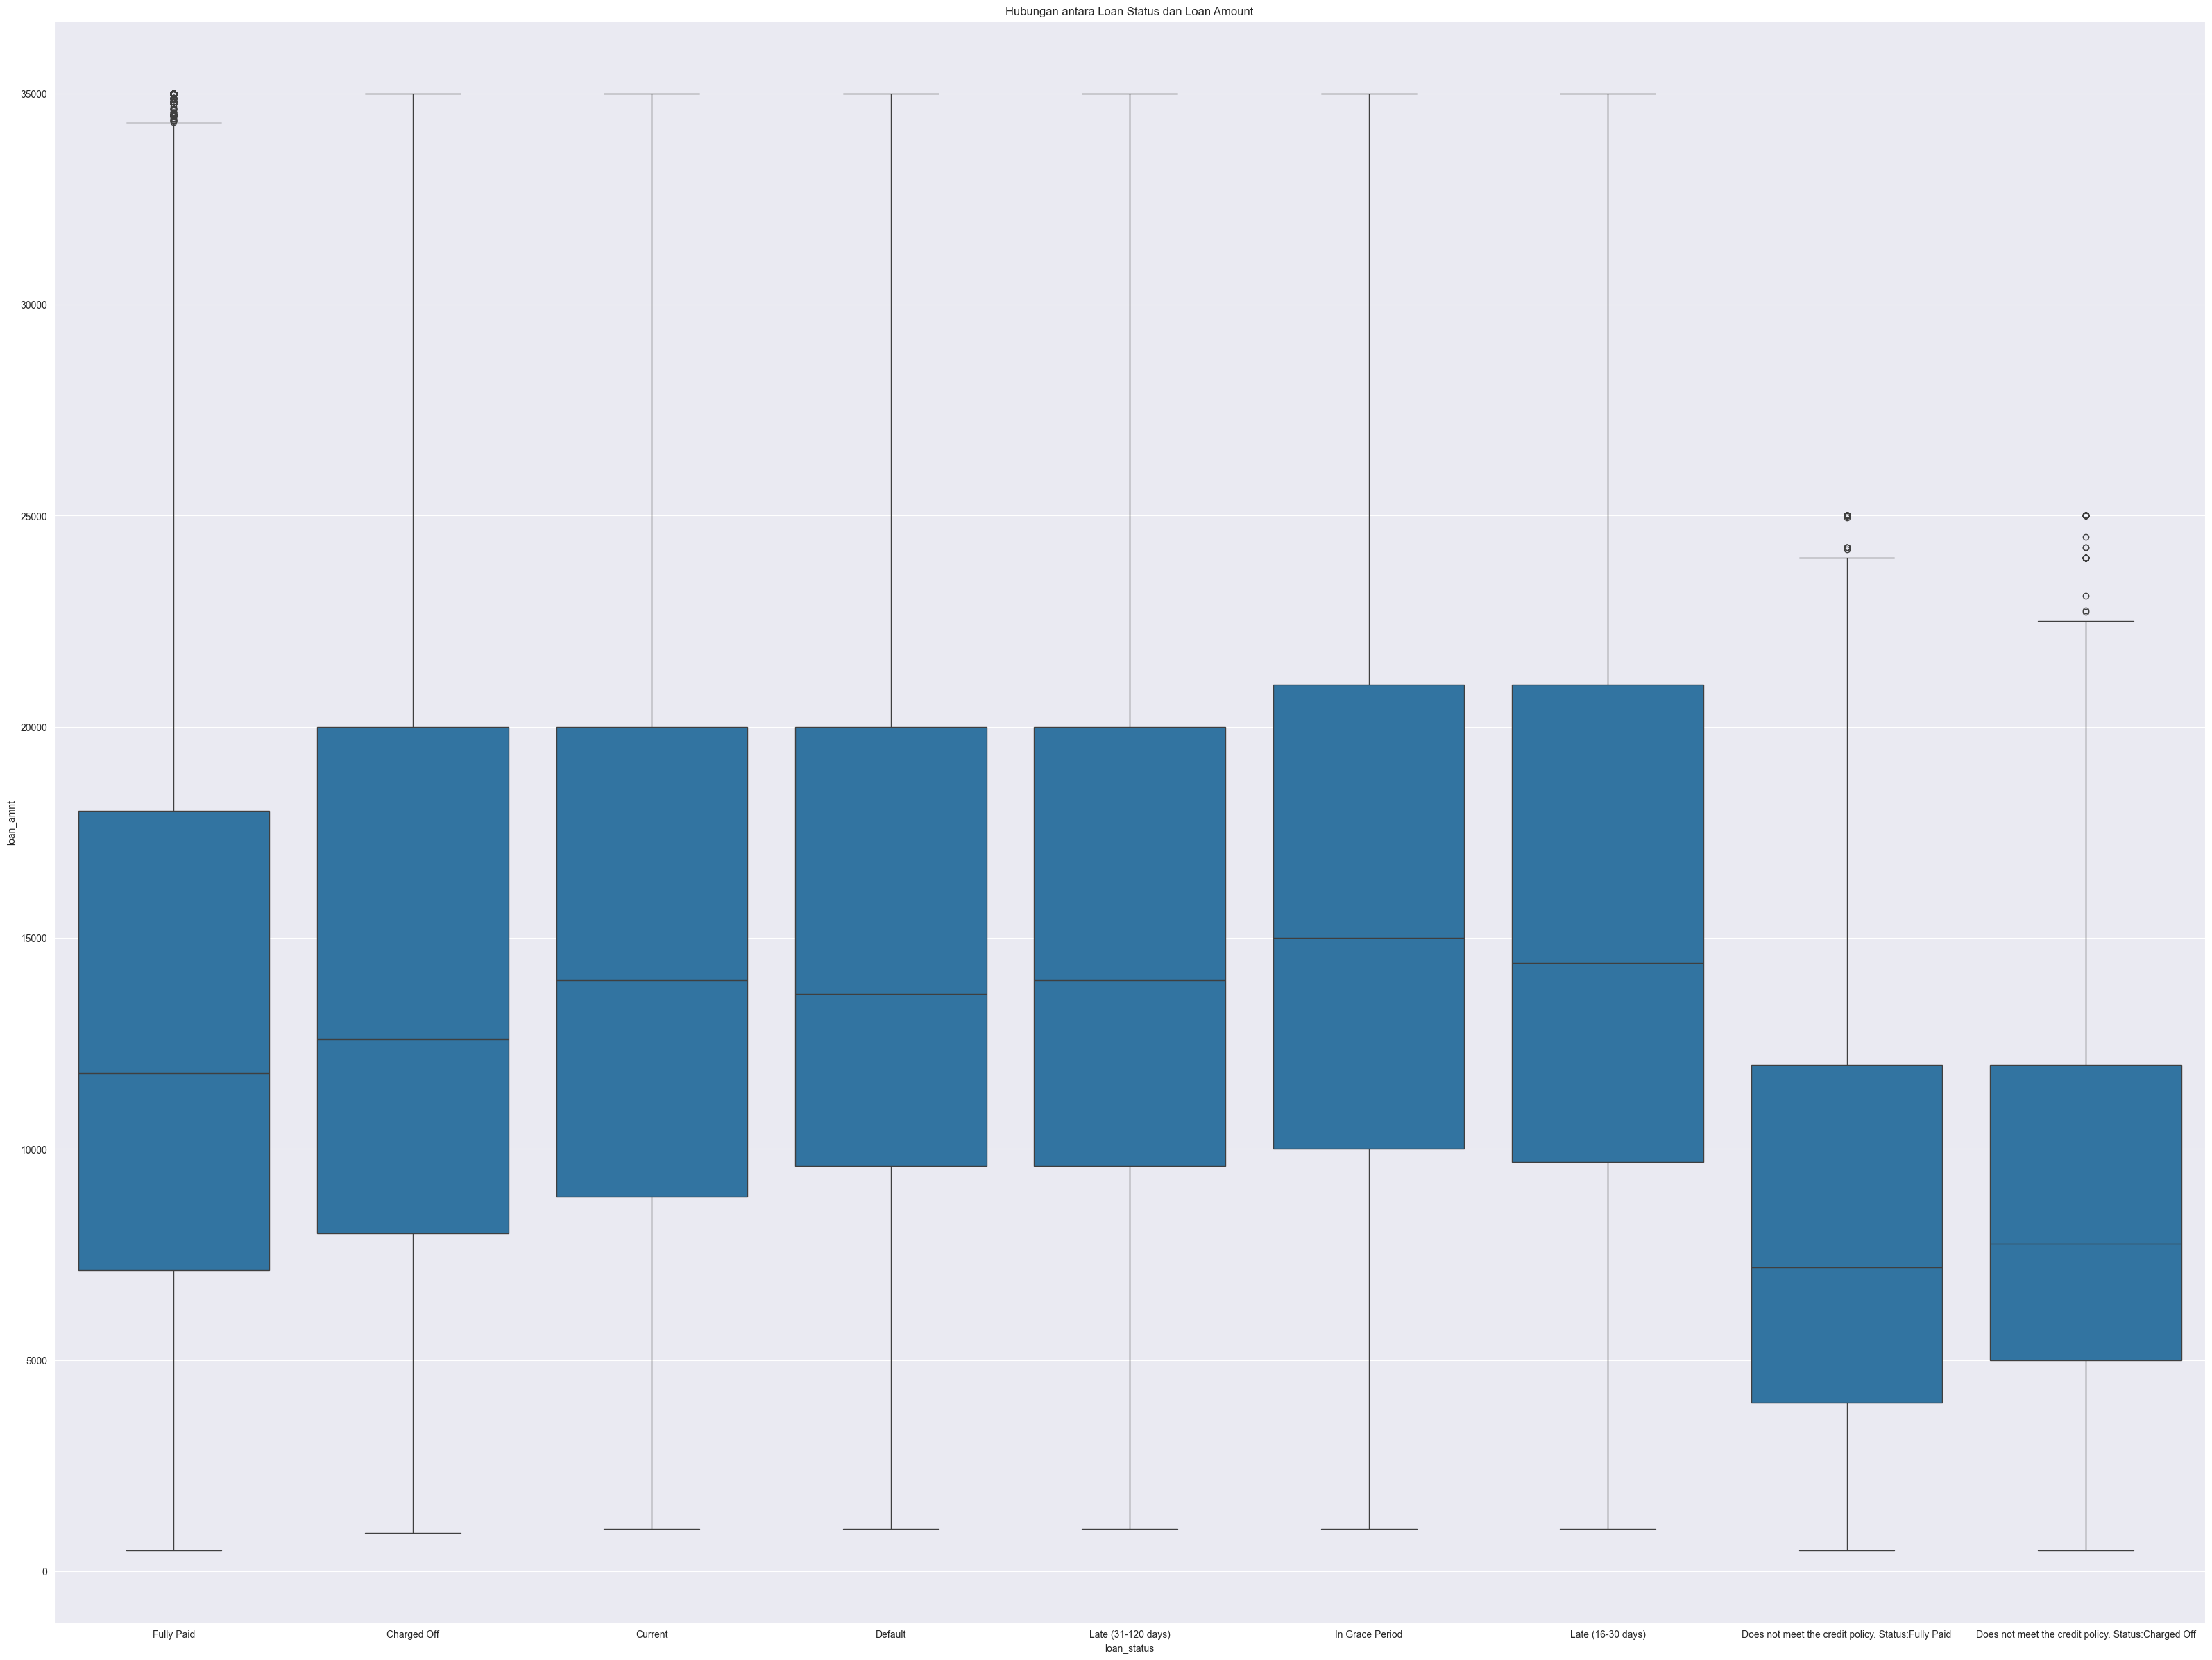

In [12]:
plt.figure(figsize=(40,30))
sns.boxplot(x='loan_status', y='loan_amnt', data=train_data)
plt.title('Hubungan antara Loan Status dan Loan Amount')
plt.show()

# Profil Peminjam

## a. Home Ownership

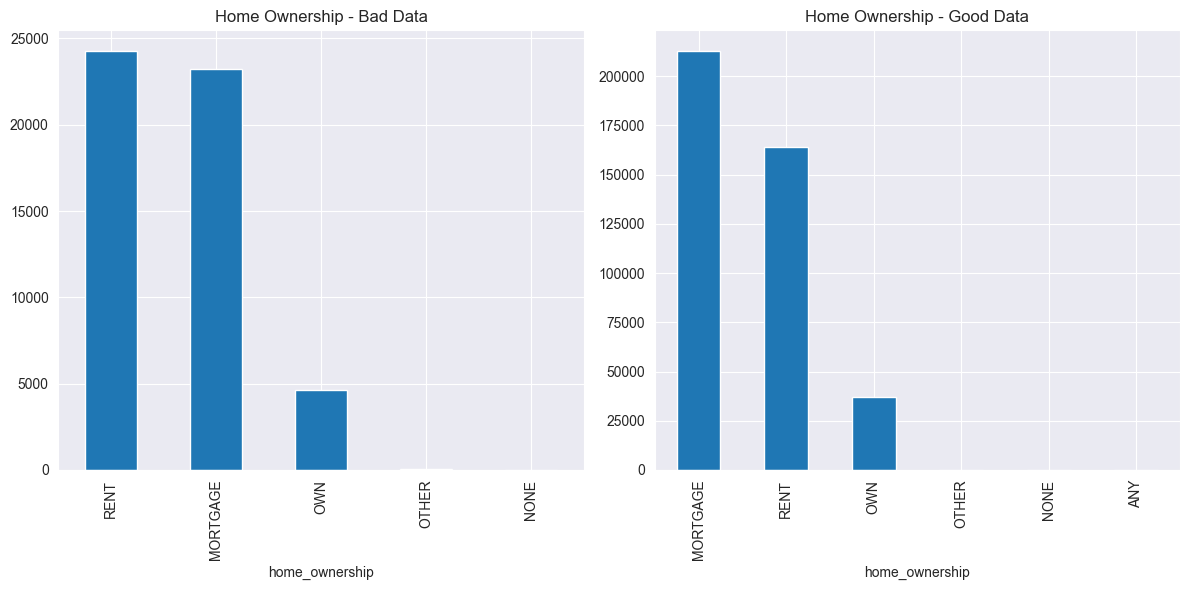

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

bad_data['home_ownership'].value_counts().plot(kind='bar', ax=axs[0])
axs[0].set_title('Home Ownership - Bad Data')

good_data['home_ownership'].value_counts().plot(kind='bar', ax=axs[1])
axs[1].set_title('Home Ownership - Good Data')

plt.tight_layout()
plt.show()

## b. State

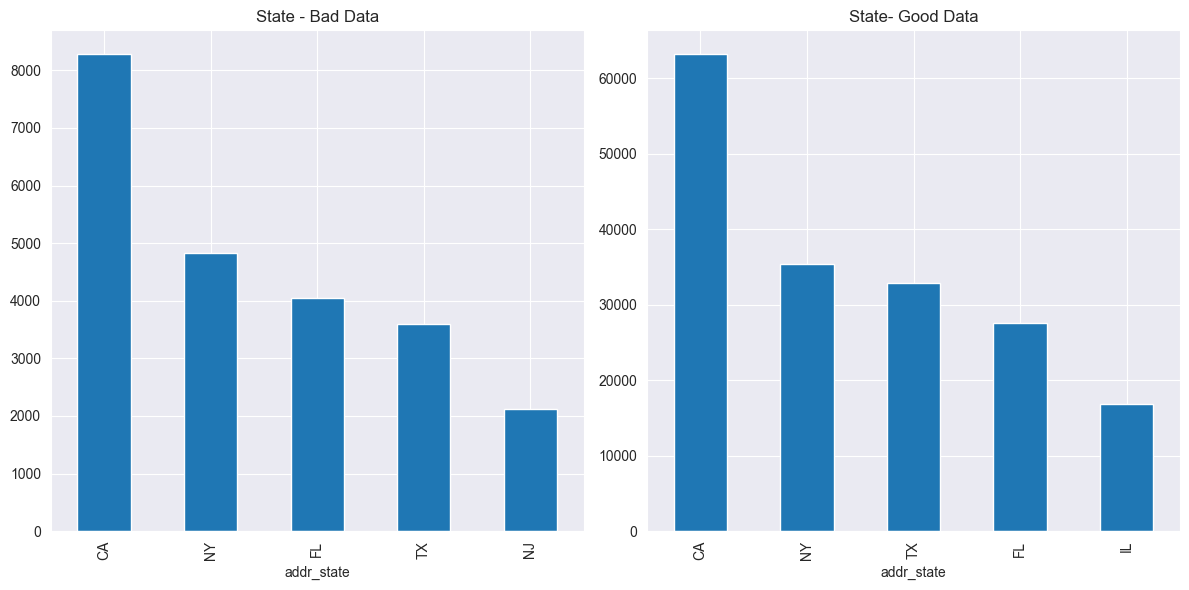

In [14]:
ifig, axs = plt.subplots(1, 2, figsize=(12, 6))

bad_data['addr_state'].value_counts().head(5).plot(kind='bar', ax=axs[0])
axs[0].set_title('State - Bad Data')

good_data['addr_state'].value_counts().head(5).plot(kind='bar', ax=axs[1])
axs[1].set_title('State- Good Data')

plt.tight_layout()
plt.show()

## c. Employee

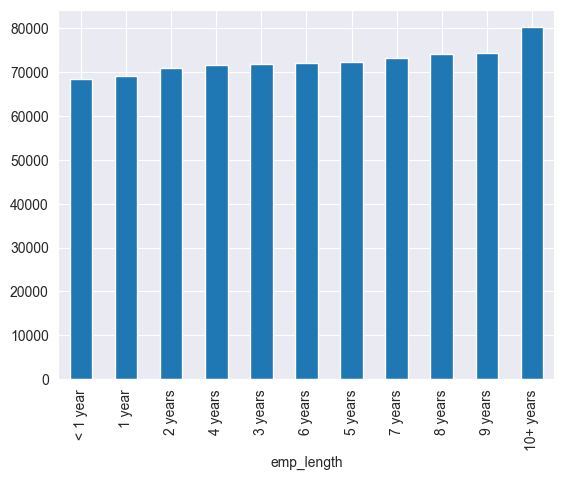

In [15]:
income_emp_length = train_data.groupby('emp_length')['annual_inc'].mean().sort_values()
income_emp_length.plot(kind='bar')
plt.show()

In [16]:
emp_data_ = train_data[['emp_length', 'annual_inc', 'loan_category']].copy(deep=True)
emp_data_['emp_length'] = emp_data_['emp_length'].replace('< 1 year', '0')
emp_data_['emp_length'] = emp_data_['emp_length'].str.extract(r'(\d+)')
emp_data_ = emp_data_.dropna()
emp_data_['emp_length'] = emp_data_['emp_length'].astype(int)
emp_data_['annual_inc'] = emp_data_['annual_inc'].astype(int)

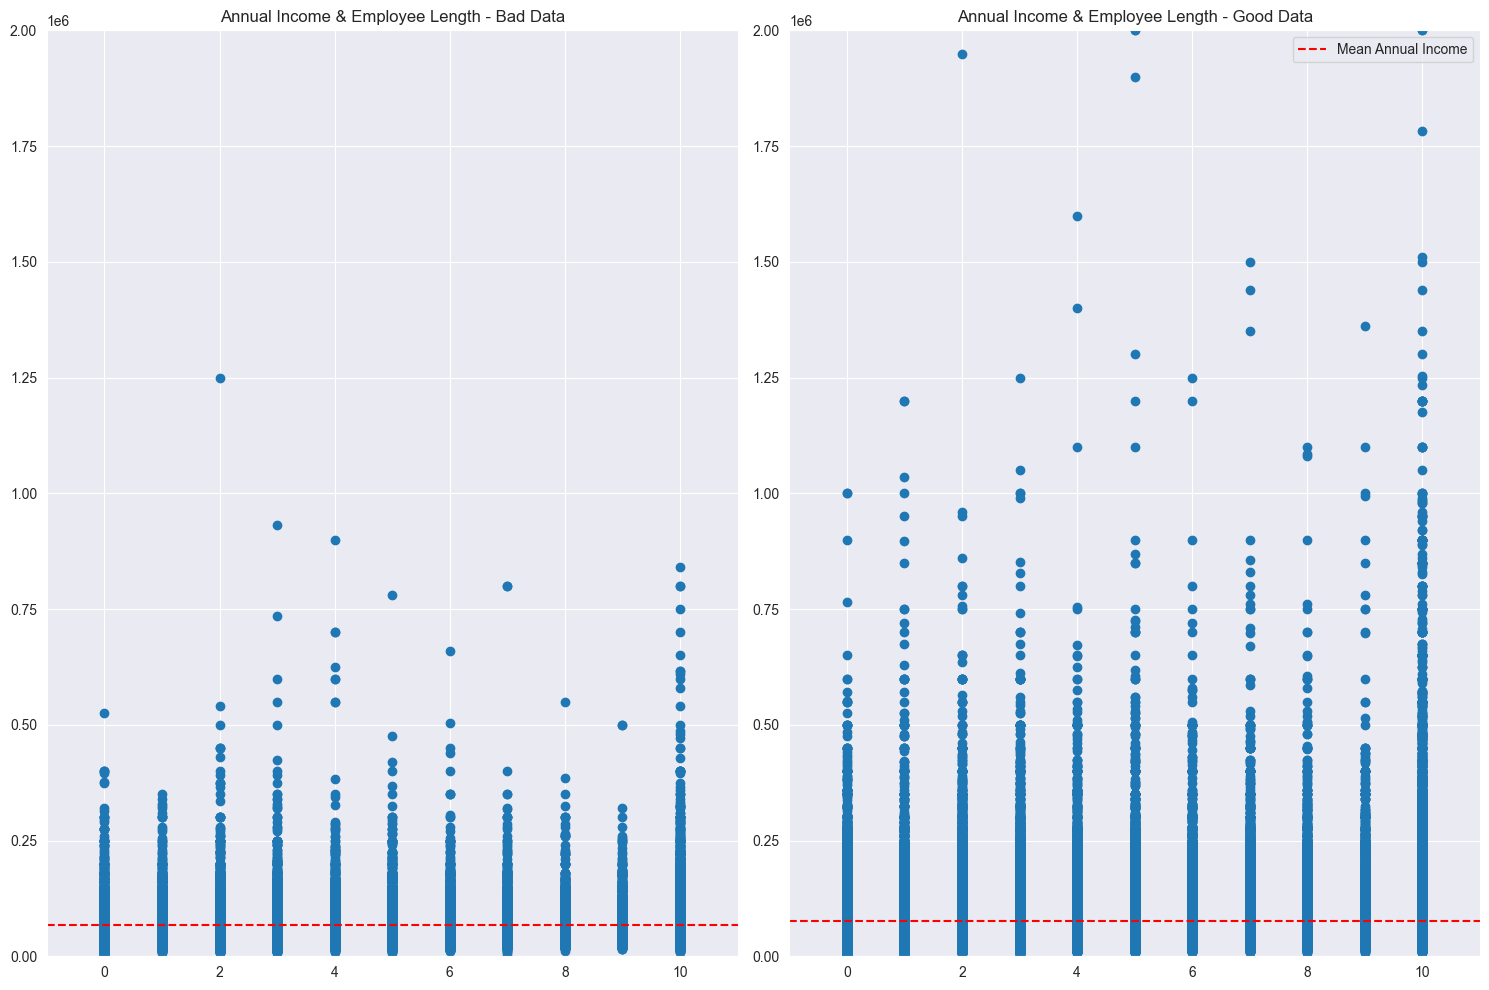

Rata-Rata Annual Income Good Data $ 75349.45
Rata-Rata Annual Income Bad Data $ 66802.44


In [17]:
bad_emp, good_emp = emp_data_[emp_data_['loan_category'] == 'Bad'],  emp_data_[emp_data_['loan_category'] == 'Good']
fig, axs = plt.subplots(1, 2, figsize=(15, 10))

axs[0].scatter(bad_emp['emp_length'], bad_emp['annual_inc'])
axs[0].axhline(y=np.mean(bad_emp['annual_inc']), color='r', linestyle='--', label='Mean Annual Income')
axs[0].set_title('Annual Income & Employee Length - Bad Data')
axs[0].set_xlim(-1, 11)
axs[0].set_ylim(0, 2000000)

axs[1].scatter(good_emp['emp_length'], good_emp['annual_inc'])
axs[1].set_title('Annual Income & Employee Length - Good Data')
axs[1].axhline(y=np.mean(good_emp['annual_inc']), color='r', linestyle='--', label='Mean Annual Income')
axs[1].set_xlim(-1, 11) 
axs[1].set_ylim(0, 2000000) 

plt.legend()
plt.tight_layout()
plt.show()
print(f"Rata-Rata Annual Income Good Data $ {np.mean(good_emp['annual_inc']):.2f}\nRata-Rata Annual Income Bad Data $ {np.mean(bad_emp['annual_inc']):.2f}")

## d. Data Catatan Publik Merugikan

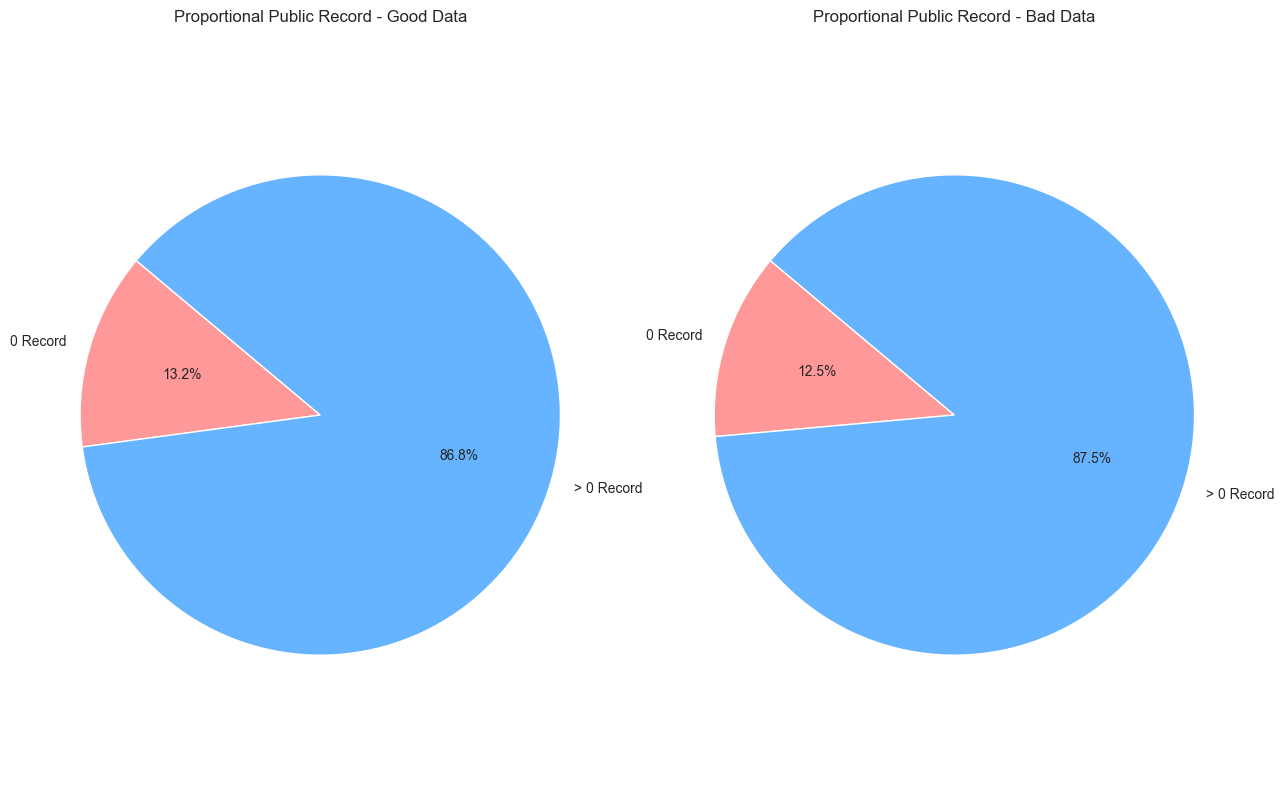

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))

bad_pub_rec_non0 = len(train_data[(train_data['pub_rec'] > 0) & (train_data['loan_category'] == 'Bad')]['pub_rec']) / len(train_data[train_data['loan_category'] == 'Bad'])
bad_pub_rec_0 = len(train_data[(train_data['pub_rec'] == 0) & (train_data['loan_category'] == 'Bad')]['pub_rec']) / len(train_data[train_data['loan_category'] == 'Bad'])
good_pub_rec_non0 = len(train_data[(train_data['pub_rec'] > 0) & (train_data['loan_category'] == 'Good')]['pub_rec']) / len(train_data[train_data['loan_category'] == 'Good'])
good_pub_rec_0 = len(train_data[(train_data['pub_rec'] == 0) & (train_data['loan_category'] == 'Good')]['pub_rec']) / len(train_data[train_data['loan_category'] == 'Good'])

sizes_good = [good_pub_rec_non0, good_pub_rec_0]
sizes_bad = [bad_pub_rec_non0, bad_pub_rec_0]

labels = ['0 Record', '> 0 Record']

colors = ['#ff9999','#66b3ff']

axs[0].pie(sizes_good, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
axs[0].axis('equal')
axs[0].set_title('Proportional Public Record - Good Data')

axs[1].pie(sizes_bad, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
axs[1].axis('equal')
axs[1].set_title('Proportional Public Record - Bad Data')

plt.show()

# Purpose

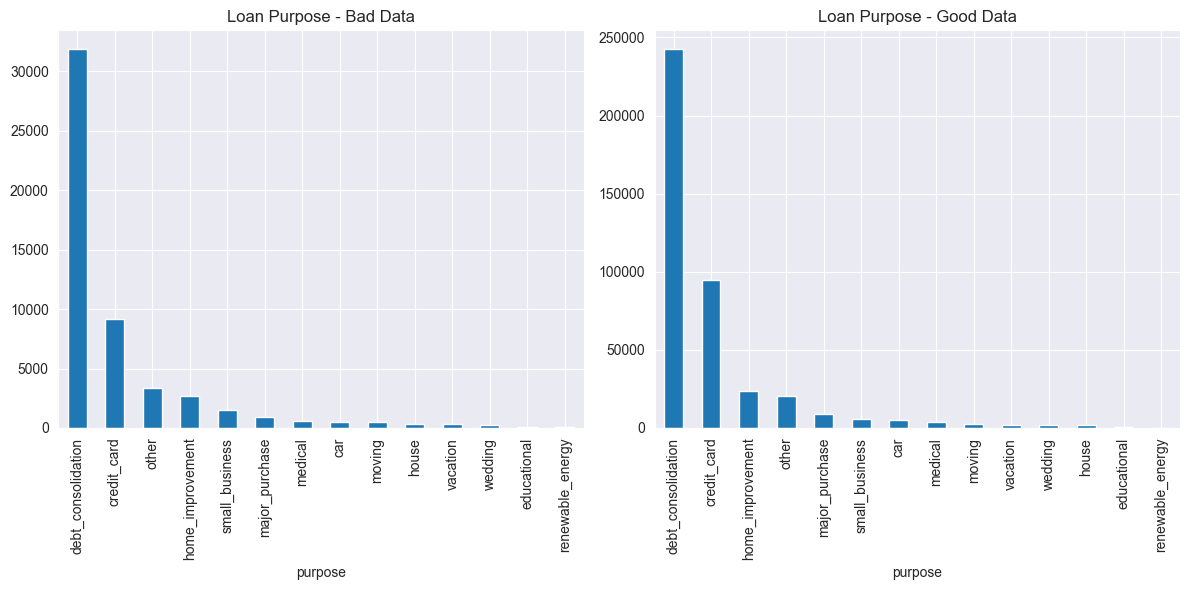

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

bad_data['purpose'].value_counts().plot(kind='bar', ax=axs[0])
axs[0].set_title('Loan Purpose - Bad Data')

good_data['purpose'].value_counts().plot(kind='bar', ax=axs[1])
axs[1].set_title('Loan Purpose - Good Data')

plt.tight_layout()
plt.show()

# Suku Bunga

# Peningkatan Fitur

### a. emp_title
Fitur 'emp_title' mengandung informasi tentang judul pekerjaan (job title) dari peminjam. Namun, terdapat beberapa nilai dalam fitur ini yang tidak sepenuhnya menggambarkan sebuah judul pekerjaan, seperti 'AIR RESOURCES BOARD' dan 'Starbucks', yang sebenarnya adalah entitas perusahaan. Kehadiran nilai-nilai semacam ini dapat menyulitkan analisis data, terutama jika kita ingin melakukan pengelompokan atau pemrosesan lanjutan.

Pentingnya memiliki data yang akurat dan relevan dalam fitur 'emp_title' terletak pada kemampuannya untuk memberikan wawasan tentang stabilitas penghasilan dan kualifikasi peminjam. Dalam analisis risiko kredit, stabilitas penghasilan adalah faktor penting dalam menilai kemampuan seorang individu untuk membayar kembali pinjaman. Sebuah pekerjaan dengan gaji yang stabil dan kualifikasi yang tinggi cenderung memberikan indikasi bahwa peminjam memiliki kemampuan finansial yang baik.

### b. purpose
Fitur 'purpose' memberikan informasi tentang tujuan peminjaman dari peminjam. Meskipun fitur ini sudah memberikan wawasan tentang tujuan peminjaman, nilai-nilainya masih bisa dikembangkan lebih lanjut agar model bisa lebih robust ketika menemui nilai yang berbeda. Pengembangan nilai dalam fitur 'purpose' dapat dilakukan dengan mempertimbangkan variasi tujuan peminjaman yang lebih luas, sehingga mencakup berbagai kebutuhan peminjam secara lebih akurat. model dapat lebih sensitif terhadap kebutuhan dan preferensi peminjam.


<Figure size 1000x600 with 0 Axes>

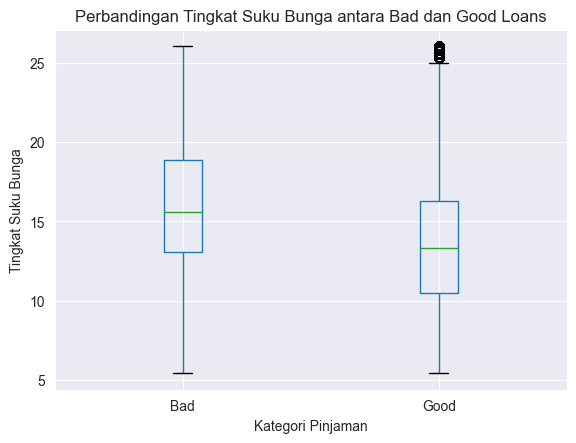

In [20]:
plt.figure(figsize=(10, 6))
train_data.boxplot(column='int_rate', by='loan_category')
plt.title('Perbandingan Tingkat Suku Bunga antara Bad dan Good Loans')
plt.xlabel('Kategori Pinjaman')
plt.ylabel('Tingkat Suku Bunga')
plt.suptitle('')
plt.show()

# Data Preprocessing

In [21]:
label_encoder = LabelEncoder()
train_data['loan_category'] = label_encoder.fit_transform(train_data['loan_category'])

## Handling Missing Data

In [22]:
non_object_data = train_data.select_dtypes(exclude='object').columns

In [45]:
imputer = KNNImputer(n_neighbors=683)
train_data[non_object_data] = imputer.fit_transform(train_data[non_object_data])

In [59]:
train_data['last_pymnt_d'] = train_data['last_pymnt_d'].fillna(train_data['last_pymnt_d'].mode()[0])
train_data['last_credit_pull_d'] = train_data['last_credit_pull_d'].fillna(train_data['last_credit_pull_d'].mode()[0])
train_data['earliest_cr_line'] = train_data['earliest_cr_line'].fillna(train_data['earliest_cr_line'].mode()[0])

# Extract Value Month

In [60]:
train_data['term_int'] = train_data['term'].str.extract(r'(\d+)').astype(int)

In [61]:
train_data['emp_length'] = train_data['emp_length'].fillna(train_data['emp_length'].mode()[0])
train_data['emp_length_int'] = train_data['emp_length'].replace('< 1 year', '0')
train_data['emp_length_int'] = train_data['emp_length'].str.extract(r'(\d+)').astype(int)

# Label Encode

In [62]:
grade = {'A':6, 'B':5, 'C':4, 'D':3, 'E':2, 'F':1, 'G':0}
train_data['grade'] = train_data['grade'].replace(grade)

In [63]:
subgrade = {}
grade = ['G', 'F', 'E', 'D', 'C', 'B', 'A']
sub = 1
for i in grade:
    for x in range(1, 6):
        subgrade[f'{i}{x}'] = sub
        sub += 1
train_data['sub_grade'] = train_data['sub_grade'].replace(subgrade)

# One Hot Encode
## Home Ownership

In [64]:
home_ownership = pd.get_dummies(train_data['home_ownership'], prefix='home_ownership', drop_first=True)
home_df = pd.concat([train_data, home_ownership], axis=1)

## Verification Status

In [65]:
verification_status = pd.get_dummies(train_data['verification_status'], prefix='ver_stat', drop_first=True)
veri_df = pd.concat([home_df, verification_status], axis=1)

## Purpose

In [66]:
purpose = pd.get_dummies(train_data['purpose'], prefix='purpose', drop_first=True)
purpose_df = pd.concat([veri_df, purpose], axis=1)

## State

In [67]:
addr_state = pd.get_dummies(train_data['addr_state'], prefix='addr_state', drop_first=True)
feature_addr_df = pd.concat([train_data['loan_category'], addr_state], axis=1)

In [68]:
X = feature_addr_df.drop('loan_category', axis=1)
y = feature_addr_df['loan_category']
rf_model = RandomForestClassifier()

rf_model.fit(X, y)
feature_importance = rf_model.feature_importances_
feature_importance_series = pd.Series(feature_importance, index=X.columns)
top_features = feature_importance_series.nlargest(5)

In [69]:
state_df = pd.concat([purpose_df, addr_state[top_features.index]], axis=1)

In [70]:
initial_list_status = pd.get_dummies(train_data['initial_list_status'], prefix='init_list_sts', drop_first=True)
init_df = pd.concat([state_df, initial_list_status], axis=1)

## Casting Data Type to Datetime

In [71]:
init_df['earliest_cr_line'] = pd.to_datetime(init_df['earliest_cr_line'], format='%b-%y')
init_df['issue_d'] = pd.to_datetime(init_df['issue_d'], format='%b-%y')
init_df['last_pymnt_d'] = pd.to_datetime(init_df['last_pymnt_d'], format='%b-%y')
init_df['last_credit_pull_d'] = pd.to_datetime(init_df['last_credit_pull_d'], format='%b-%y')

In [196]:
train_data = init_df.copy(deep=True)

In [197]:
bool_cols = train_data.select_dtypes(include=bool).columns
train_data[bool_cols] = train_data[bool_cols].astype(int)

# Feature Engineering

In [198]:
train_data['last_pymnt_days'] = (train_data['last_pymnt_d'] - train_data['issue_d']).dt.days
train_data['first_crdt_to_new'] = (train_data['issue_d'] - train_data['earliest_cr_line']).dt.days
train_data['last_data_pull'] = (train_data['last_credit_pull_d'] - train_data['issue_d']).dt.days

In [199]:
train_data['loan_to_income_ratio'] = train_data['loan_amnt'] / train_data['annual_inc']
train_data['recovery_rate'] = train_data['recoveries'] / train_data['funded_amnt']
train_data['payment_to_income_ratio'] = train_data['installment'] / (train_data['annual_inc'] / 12)
train_data['debt_to_income_ratio'] = (train_data['funded_amnt'] - train_data['total_rec_prncp']) / train_data['annual_inc']
train_data['fraction_of_total_payments_received'] = train_data['total_pymnt'] / train_data['funded_amnt']
train_data['principal_received_ratio'] = train_data['total_rec_prncp'] / train_data['funded_amnt']
train_data['inquiries_per_month'] = train_data['inq_last_6mths'] / 6

# Drop Unnecessary Data

In [200]:
train_data.drop(columns=['emp_title','home_ownership', 'verification_status', 'purpose',
                         'addr_state', 'initial_list_status' ,'pymnt_plan', 'title', 'zip_code', 'url', 'issue_d', 
                         'loan_status','last_credit_pull_d', 'application_type', 'emp_length', 'earliest_cr_line', 'last_pymnt_d','Unnamed: 0', "id", "term", "member_id" ], inplace=True)

# Outliers

In [168]:
def IQR_outliers(data: pd.DataFrame):
    Q1 = np.percentile(data.values, 25)
    Q3 = np.percentile(data.values, 75)
    IQR_ = Q3 - Q1
    batas_bawah = Q1 - 1.5 * IQR_
    batas_atas = Q3 + 1.5 * IQR_
    outliers = data[(data < batas_bawah) | (data > batas_atas)]
    return outliers

def outliers(data: pd.DataFrame) -> pd.DataFrame:
    for i in data.columns:
        outliers = IQR_outliers(data[i])
        if len(outliers) > 0:
            data.loc[outliers.index, i] = np.mean(data[i])
    return data

train_data_ = outliers(train_data)

# Deteksi Fitur Penting

In [201]:
X = train_data.drop('loan_category', axis=1)
y = train_data['loan_category']
rf_model = RandomForestClassifier()

rf_model.fit(X, y)
feature_importance = rf_model.feature_importances_
feature_importance_series = pd.Series(feature_importance, index=X.columns)
top_features = feature_importance_series.nlargest(20)

In [202]:
top_features

recoveries                             0.123911
principal_received_ratio               0.102747
collection_recovery_fee                0.085600
recovery_rate                          0.083532
fraction_of_total_payments_received    0.080749
out_prncp                              0.080647
debt_to_income_ratio                   0.075996
out_prncp_inv                          0.062482
last_pymnt_days                        0.043702
total_rec_prncp                        0.040174
last_pymnt_amnt                        0.027211
last_data_pull                         0.021597
total_pymnt                            0.015767
total_pymnt_inv                        0.013810
total_rec_late_fee                     0.010380
installment                            0.009865
funded_amnt_inv                        0.008123
total_rec_int                          0.007712
loan_amnt                              0.007525
int_rate                               0.007122
dtype: float64

# Final DF

In [232]:
final_data = train_data[top_features.index].copy()

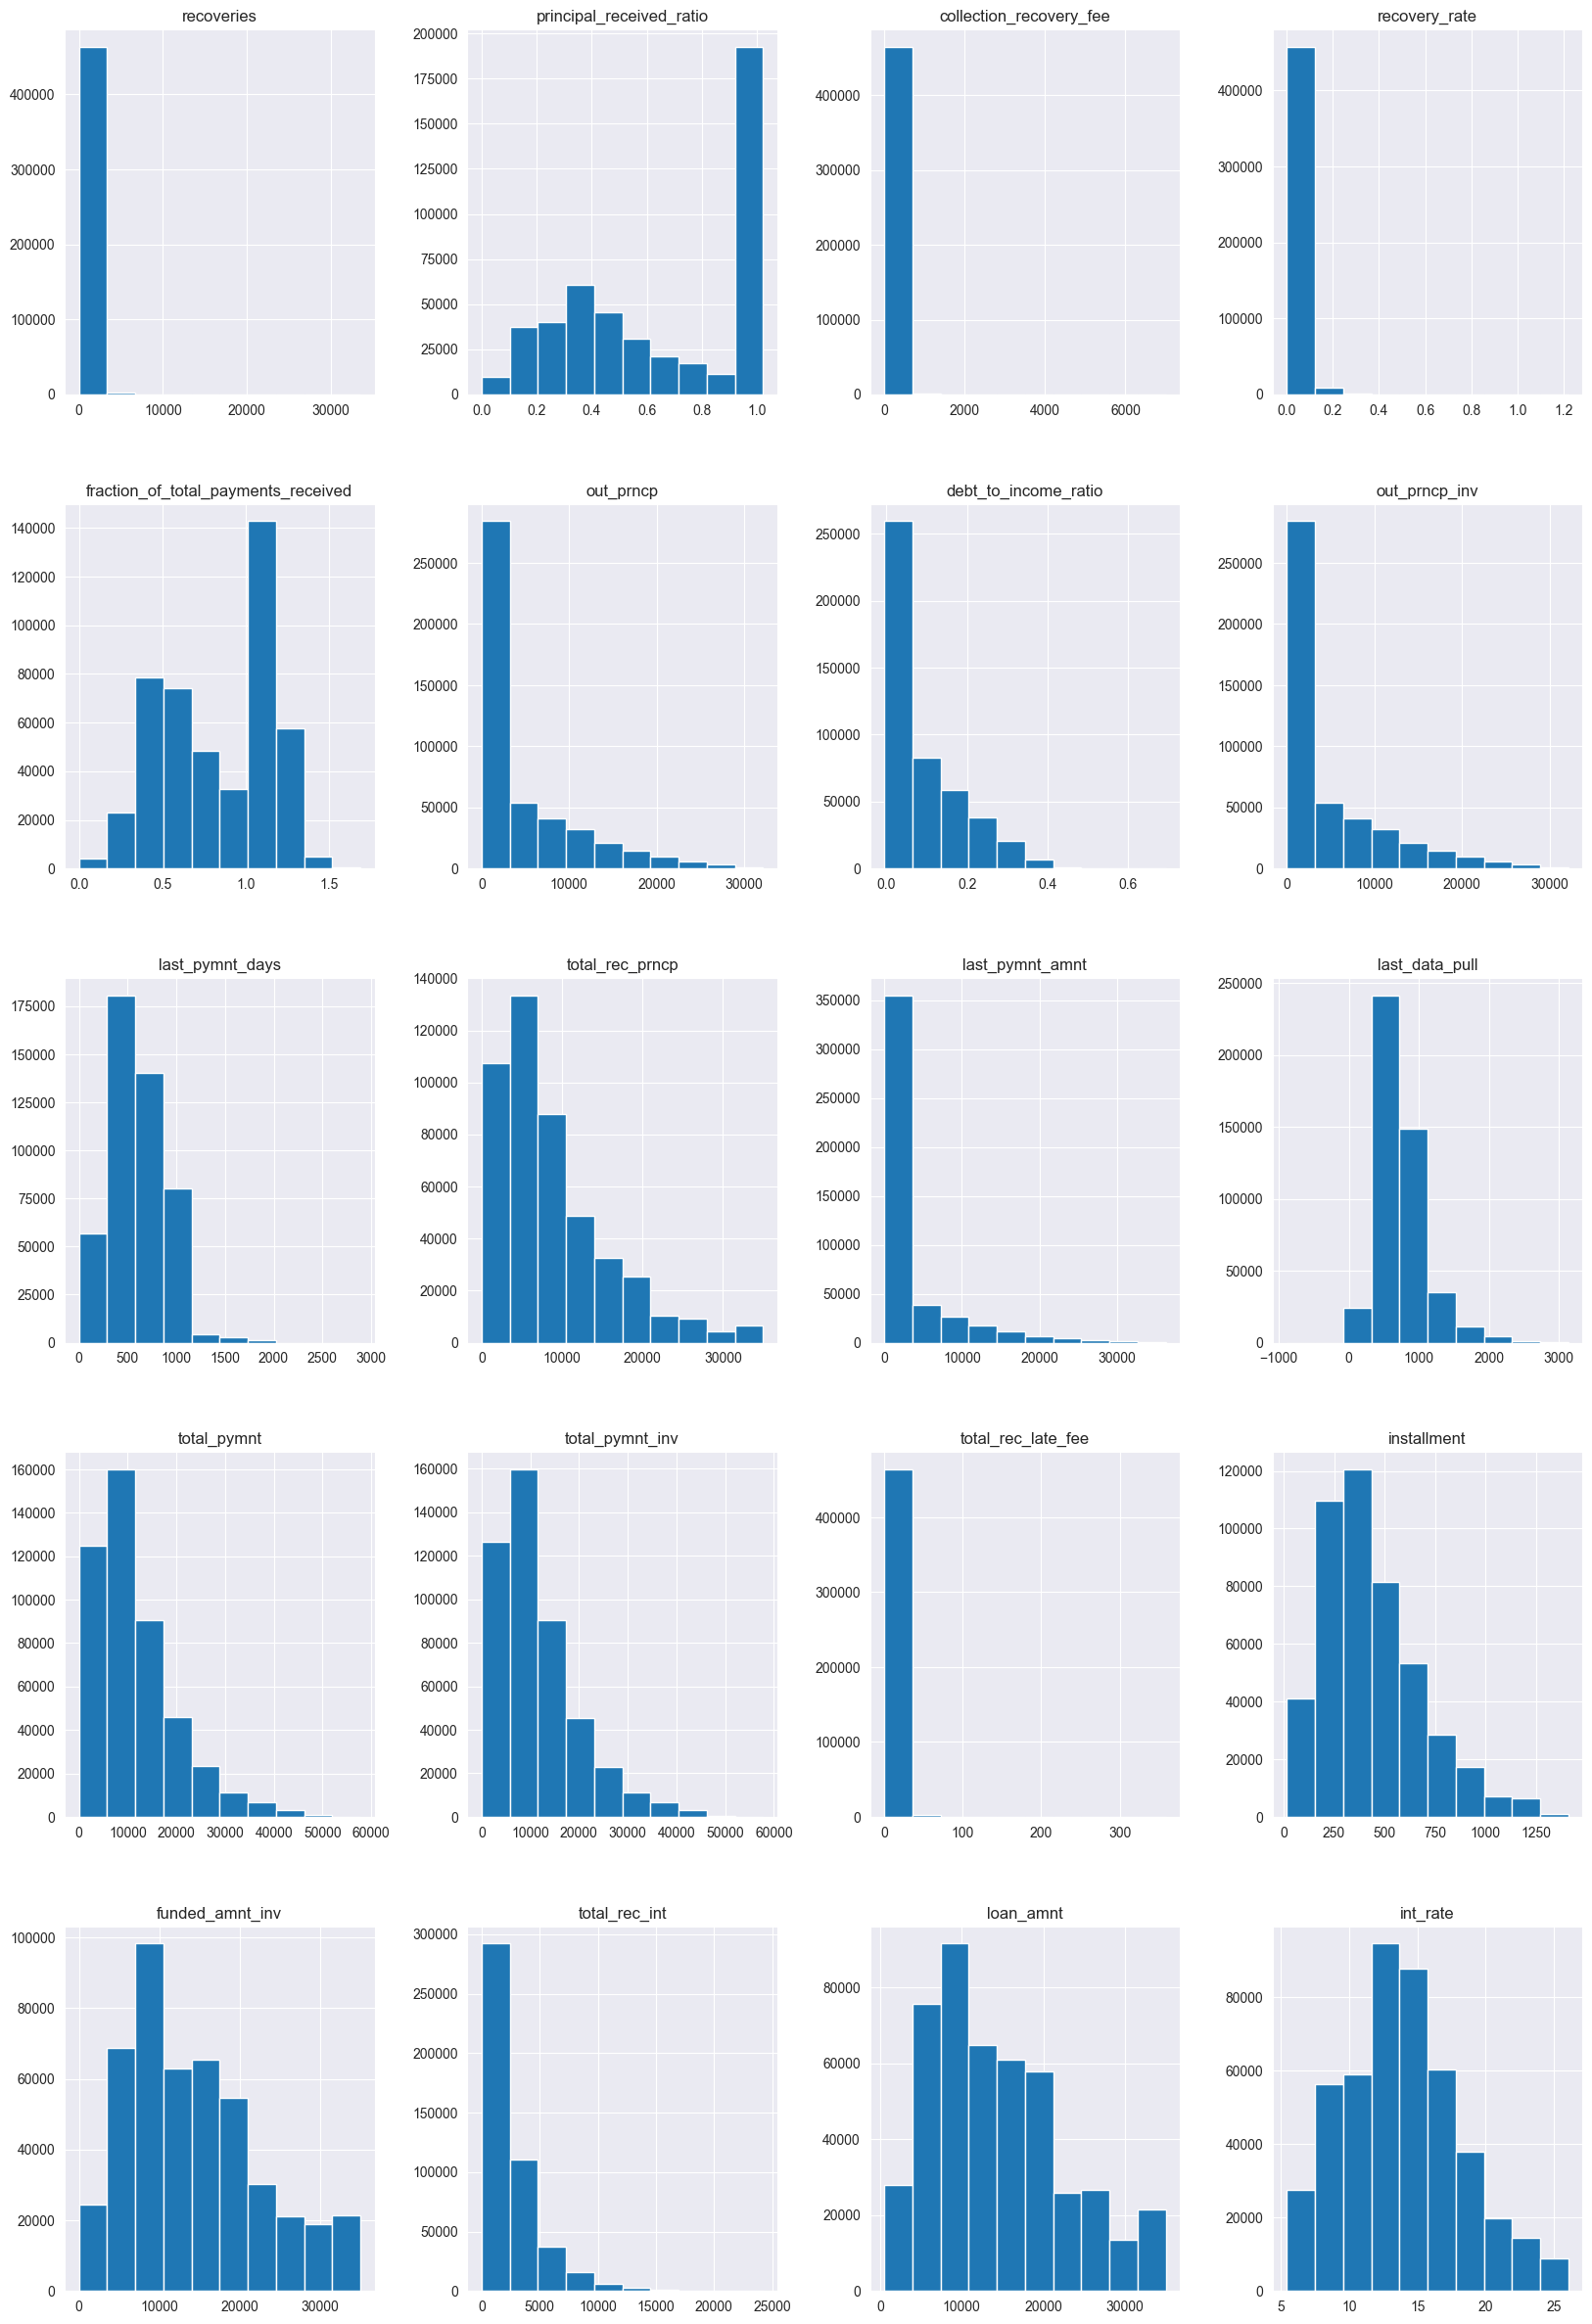

In [233]:
final_data.hist(figsize=(20,30))
plt.show()

In [235]:
final_data['principal_received_ratio'] = np.sqrt(final_data['principal_received_ratio'])
final_data['fraction_of_total_payments_received'] = np.cbrt(final_data['fraction_of_total_payments_received'])
final_data['last_pymnt_days'] = np.sqrt(final_data['last_pymnt_days'])
final_data['total_rec_prncp'] = np.cbrt(final_data['total_rec_prncp'])
final_data['last_data_pull'] = np.cbrt(final_data['last_data_pull'])
final_data['total_pymnt_inv'] = np.cbrt(final_data['total_pymnt_inv'])
final_data['total_pymnt'] = np.cbrt(final_data['total_pymnt'])
final_data['installment'] = np.sqrt(final_data['installment'])
final_data['int_rate'] = np.cbrt(final_data['int_rate'])
final_data['total_rec_int'] = np.cbrt(final_data['total_rec_int'])
final_data['loan_amnt'] = np.cbrt(final_data['loan_amnt'])

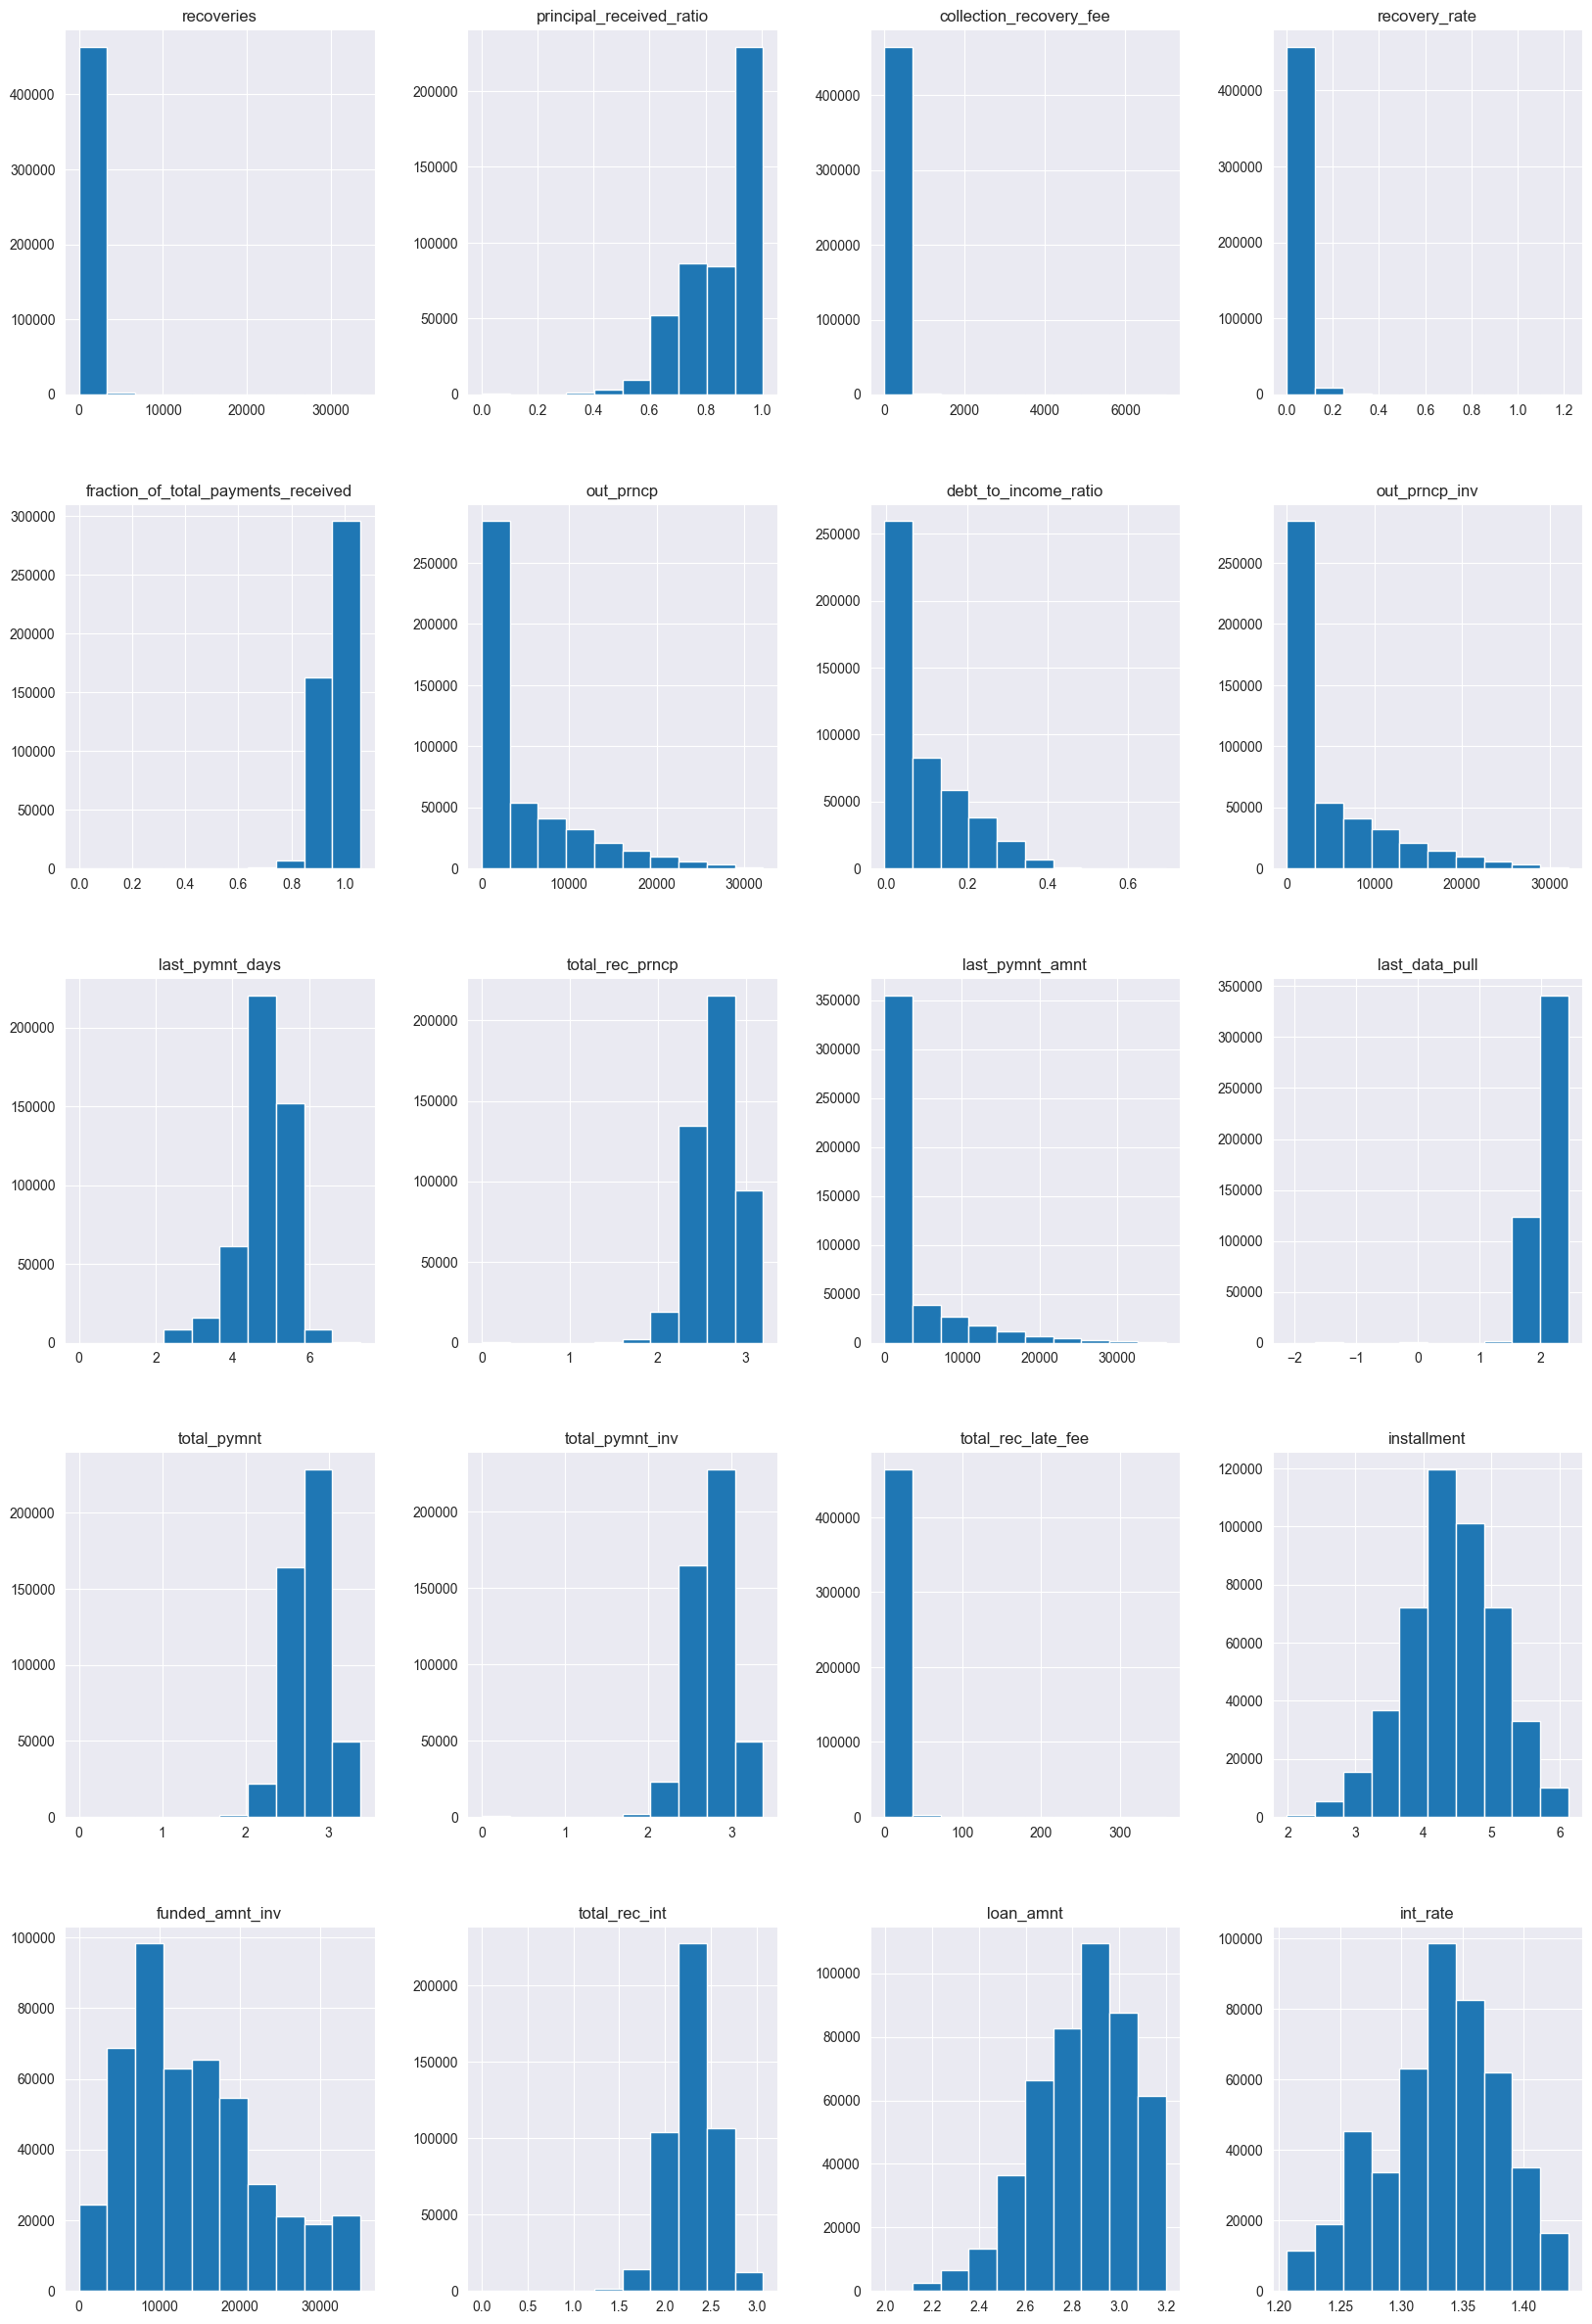

In [236]:
final_data.hist(figsize=(20,30)) 
plt.show()

# Standart Scaler

In [237]:
scaler = MinMaxScaler()
X_final = scaler.fit_transform(final_data) 
X = pd.DataFrame(X_final)

# Handling Imbalance Data

In [239]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X, y)

# Train Test Split

In [241]:
X_train, X_test, y_train, y_test = train_test_split(X_train_resampled, y_train_resampled, test_size=0.2, random_state=11)

# Modeling

In [249]:
def objective(trial):
    C = trial.suggest_float("C", 1e-5, 1e5)
    solver = trial.suggest_categorical("solver", ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'])
    penalty = trial.suggest_categorical("penalty", ["l1", "l2", "elasticnet"])
    tol = trial.suggest_float("tol", 1e-4, 1e-1)
    max_iter = trial.suggest_int("max_iter", 100, 1000)
    l1_ratio = trial.suggest_float('l1_ratio',  1e-4, 1e-1)

    model = LogisticRegression(C=C, solver=solver, penalty=penalty, tol=tol, max_iter=max_iter, l1_ratio=l1_ratio)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)

    return f1


study =  optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1000)

best_params = study.best_params
print("Best parameters:")
for key, value in best_params.items():
    print(f"  {key}: {value}")

best_model = LogisticRegression(**best_params)
best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_test)
f1_best = f1_score(y_test, y_pred_best)
print(f"Best F1 score: {f1_best}")


[I 2024-05-13 18:40:37,057] A new study created in memory with name: no-name-446fb3e8-316c-42e5-92bf-7bc62621a0e0
[I 2024-05-13 18:42:59,070] Trial 0 finished with value: 0.9120357122417444 and parameters: {'C': 70508.03654630015, 'solver': 'liblinear', 'penalty': 'l1', 'tol': 0.02077528008885938, 'max_iter': 747, 'l1_ratio': 0.026153049328529736}. Best is trial 0 with value: 0.9120357122417444.
[I 2024-05-13 18:43:14,150] Trial 1 finished with value: 0.9340511907102624 and parameters: {'C': 21039.430888219373, 'solver': 'saga', 'penalty': 'l1', 'tol': 0.015097169711685655, 'max_iter': 564, 'l1_ratio': 0.06974339492245897}. Best is trial 1 with value: 0.9340511907102624.
[I 2024-05-13 18:43:17,261] Trial 2 finished with value: 0.9060302113415971 and parameters: {'C': 43341.701875997605, 'solver': 'liblinear', 'penalty': 'l2', 'tol': 0.05736784601831903, 'max_iter': 882, 'l1_ratio': 0.034433663627406914}. Best is trial 1 with value: 0.9340511907102624.
[W 2024-05-13 18:43:17,263] Trial 

ValueError: Solver lbfgs supports only 'l2' or None penalties, got l1 penalty.

In [251]:
model_1 = LogisticRegression(C= 21039.430888219373, solver= 'saga', penalty ='l1', tol= 0.015097169711685655, max_iter= 564, l1_ratio= 0.06974339492245897)
model_1.fit(X_train, y_train)
y_pred = model_1.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.89      0.93     82713
         1.0       0.90      0.97      0.93     82927

    accuracy                           0.93    165640
   macro avg       0.93      0.93      0.93    165640
weighted avg       0.93      0.93      0.93    165640


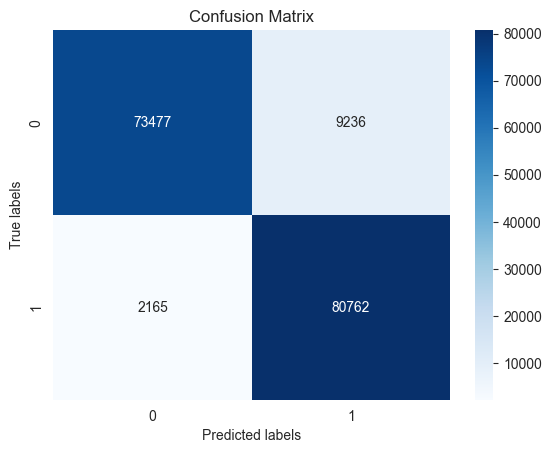

In [254]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

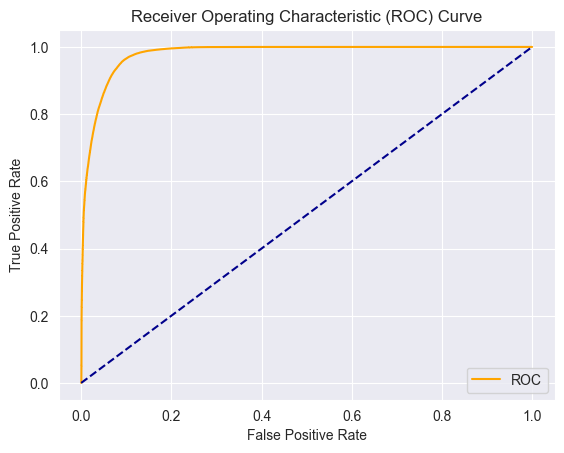

In [256]:
y_pred_proba = model_1.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()
